In [78]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import brentq, curve_fit
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
import time
pio.renderers.default = "browser"

#ignoring the covariance computation failure when computing the surface for now.
# it happens for a few sets of svi_params
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=OptimizeWarning)

# svi surface function
def svi_w(k, a, b, rho, m, phi):
    return a + b * (rho * (k - m) + np.sqrt((k - m) ** 2 + phi ** 2))

# Black–Scholes call price, quite standard
def bs_call(s, k, rr, sigma, tt):
    d1 = (np.log(s / k) + (rr + 0.5 * sigma ** 2) * tt) / (sigma * np.sqrt(tt))
    d2 = d1 - sigma * np.sqrt(tt)
    return s * norm.cdf(d1) - k * np.exp( -rr * tt) * norm.cdf(d2)

def iv_res(sig):
            return bs_call(spot, K, r, sig, T) - p

<h2> Stochastic Volatility inspired (SVI) Volatility surface</h2>

<h3> Introduction</h3>
The volatility smile, which only became widespread after the 1987 crash (or at least rarely), is the name given to the curve formed from implied volatility as a function of strike price, K. It was named that for obvious reasons given you have seen at least one. That's right, it's because the smile that spreads on anyone's face as they see they can get a rough measure of implied volatility (now the future is less uncertain). They are useful from different perspectives. Perhaps someone is trying to profit from arbitrage opportunities from mispricing of options, or simply trying to guage market sentiment (they arise mostly from behaviour after all. The surface aspect comes about when the implied volatility function is not only a function of strike price but also of time to maturity, $\sigma (K,T), creating a 3D space and from that a surface. 

SVI methods came about because the methods previously used describing the volatility smiles were not satisfactory for guaranteeing no arbitrage. Speifically SVI deals with butterfly and calendar-spread arbitrage. It does this by incorporating stochastic volatility into the model. A classical approach would have involved using a spline between points to interpolate. Comparing the two methods, you'll find a spline to show a lot of unnatural features that are not reflective of the market, from which arbitrage is possible. The SVI approach provides a mathematical function given the points that tries to ensure that the points along the surface do not bring about arbitrage (which can look a lot smoother).

The code aims to produce a volatility surface using SVI methods. It takes data from the market, cleans the data slightly (illiquid strikes), then fits the SVI curve, and finally builds the surface.

Note: this is still in working progress and will mostly be labelled where the progress is working.

In [79]:
r = 0.04 # risk free rat somewhat around that of the US treasury, I could do with estimating better
max_expiries = 60 # no. of expiries to pull
min_volume = 22 # trying to avoid illiquid contracts (for popular stocks it may happen for deep ITM and far OTM)
min_open_int = 1147 # making sure the contracts are active

# upper and lower bounds for moneyness
moneyness_lo = 0.8 
moneyness_hi = 1.2

stock = "AMZN"
ticker = yf.Ticker(stock)
spot = float(ticker.history(period="2d")["Close"].iloc[-1])

In [80]:
records = []

for exp in ticker.options[:max_expiries]:
    # avoid getting blocked by enquiry limit
    # mostly fixed with package update
    time.sleep(0.1)
    
    calls = ticker.option_chain(exp).calls
    

    # Not an important date, but just so if opened at some time that there is not a data error
    ref_date = pd.to_datetime("04.08.2025", dayfirst=True).normalize()
    hist = ticker.history(
        start=(ref_date - pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
        end=(ref_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
    )
    
    spot = float(hist["Close"].dropna().iloc[-1])
    T = (pd.to_datetime(exp) - ref_date).days / 365.0

    # filtering today's expired contracts
    if T <= 0:
        continue
    
    # use filters mentioned above
    calls = calls[
        (calls.volume > min_volume) &
        (calls.openInterest > min_open_int) &
        calls.impliedVolatility.notna()
    ]
    
    # moneyness between given range 
    calls["moneyness"] = spot / calls.strike
    calls = calls[calls.moneyness.between(moneyness_lo, moneyness_hi)]
    
    for _, row in calls.iterrows():
        K = float(row.strike)
        p = float(row.lastPrice)
        if p <= 0:
            continue
        
        # try-except added from errors in rootfinding
        try:
            iv_clean = brentq(iv_res, 1e-4, 4.0)
            records.append((exp, K, T, iv_clean))
        except ValueError:
            pass

# build DataFrame
opts = pd.DataFrame(records, columns=["expiry","K","T","IV"])
print(calls.volume.describe())
print(calls.openInterest.describe())

count      5.000000
mean      60.000000
std       34.590461
min       28.000000
25%       34.000000
50%       53.000000
75%       71.000000
max      114.000000
Name: volume, dtype: float64
count       5.000000
mean     2364.400000
std      1621.240667
min      1444.000000
25%      1545.000000
50%      1631.000000
75%      1958.000000
max      5244.000000
Name: openInterest, dtype: float64


In [81]:
svi_params = {}

for exp in opts.expiry.unique():
    opts_e = opts[opts.expiry == exp].copy()
    T0 = opts_e["T"].iloc[0] # time to expiry
    F = spot * np.exp(r * T0) # forward price
    
    opts_e["k"] = np.log(opts_e["K"] / F) # log moneyness for SVI framework
    opts_e["w"] = (opts_e["IV"] ** 2) * T0 # total variance (being the square of volatility)
    
    k_data, w_data = opts_e["k"].values, opts_e["w"].values
    
    p0 = [np.median(w_data), 0.1, 0.0, 0.0, 0.1] # initial guess
    bounds = ([0, 0, -0.999, -np.inf, 1e-6], [np.inf, np.inf, 0.999, np.inf, np.inf])
    
    try:
        params,_ = curve_fit(svi_w, k_data, w_data,
                              p0 = p0, bounds = bounds, maxfev = 20000)
        svi_params[exp] = params
    except Exception as e:
        print(f"[!] SVI fit failed for {exp}: {e}")

In [82]:
common_K = np.linspace(opts.K.min(), opts.K.max(), 50)
common_T = np.array(sorted({round(x, 6) for x in opts["T"]}))

KK, TT = np.meshgrid(common_K, common_T)
IV_grid = np.full(KK.shape, np.nan)

for i, T0 in enumerate(common_T):
    exp_match = next((e for e in svi_params
                      if abs(opts[opts.expiry==e]["T"].iloc[0] - T0)<1e-6),
                     None)
    # skips invalid T0
    if not exp_match:
        print("no match")
        continue
    
    a,b,rho,m,phi = svi_params[exp_match]
    F = spot * np.exp(r * T0)
    k_vals = np.log(common_K / F)
    w_vals = svi_w(k_vals, a, b, rho, m, phi)
    IV_grid[i,:] = np.sqrt(w_vals / T0)

fig = go.Figure(data = [go.Surface(x = common_K, y = common_T, z = IV_grid)])
fig.update_layout(
    title=f"{stock} SVI Vol Surface",
    scene=dict(xaxis_title = "Strike", yaxis_title = "Time to Expiry (yrs)", zaxis_title = "Implied Vol")
)
#fig.show()
fig.write_html("vol_surface.html", auto_open=True)

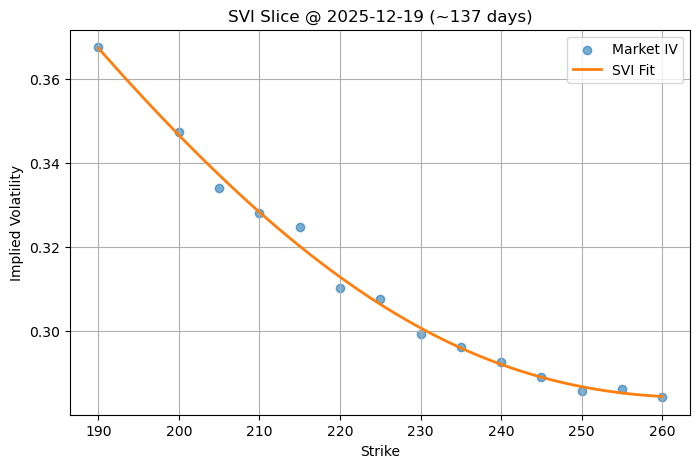

In [83]:
mid = common_T[len(common_T)//2]
exp_mid = next(e for e in svi_params
               if abs(opts[opts.expiry == e]["T"].iloc[0] - mid)<1e-6)
a, b, rho, m, phi = svi_params[exp_mid]

F = spot * np.exp(r * mid)

Ks = np.linspace(opts[opts.expiry == exp_mid]["K"].min(),
                     opts[opts.expiry == exp_mid]["K"].max(), 100)
k_vals = np.log(Ks / F)
w_vals = svi_w(k_vals, a, b, rho, m, phi)
iv_fit = np.sqrt(w_vals / mid)

plt.figure(figsize=(8, 5))
plt.scatter(opts[opts.expiry == exp_mid]["K"], opts[opts.expiry == exp_mid]["IV"],
            alpha=0.6, label="Market IV")
plt.plot(Ks, iv_fit, color="C1", lw=2, label="SVI Fit")
plt.title(f"SVI Slice @ {exp_mid} (~{mid*365:.0f} days)")
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.legend(); plt.grid(True)
plt.show()
